In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from itertools import product
from sfp_nsdsyn import utils, sfm, tuning
from sfp_nsdsyn.visualization import plot_1D_model_results as vis1D
from pysurfer.mgz_helper import get_vertices_in_labels, read_label, get_existing_labels_only
from pysurfer.freeview_helper import retinotopy_colors

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Configurations

In [15]:
nsd_dir ='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset'
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fs_subj_dir='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/freesurfer'
overlay_dir='/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn'
fig_dir='/Volumes/server/Projects/sfp_nsd/derivatives/figures/'
sn_list = [f'subj{sn:02d}' for sn in np.arange(1,9)]

In [16]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['HelveticaNeue', 'Helvetica', 'Arial'],
             'size': 10}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
#mpl.rcParams['figure.dpi'] = 72*2
#mpl.rcParams['savefig.dpi'] = 72*4

In [64]:
labels = ['V1v', 'V2v','V3v','V3d','A1']
sn = 'subj01'
hemi = 'lh'
label_path = [os.path.join(fs_subj_dir, sn, 'label', f'{hemi}.V1v.label')]

In [65]:
lh_rois, lh_voxels = {}, {}
rh_rois, rh_voxels = {}, {}
my_val = 'r2'
ref_frame = 'absolute'

for sn in sn_list:
    label_dir = os.path.join(fs_subj_dir, sn, 'label')
    lh_labels, lh_label_paths = get_existing_labels_only(labels, label_dir, 'lh', return_paths=True)
    rh_labels, rh_label_paths = get_existing_labels_only(labels, label_dir, 'rh', return_paths=True)

   # mgz_path = os.path.join(overlay_dir, f"lh.mask-r2_sub-{sn}_value-{my_val}_thres-0.2_frame-{ref_frame}.mgz")
    #mgz_path = os.path.join(overlay_dir, f'lh.sub-{sn}_value-{my_val}.mgz')
    mgz_path = os.path.join(overlay_dir, f'lh.sub-{sn}_value-{my_val}_frame-{ref_frame}.mgz')
    lh_rois[sn], lh_voxels[sn] = get_vertices_in_labels(mgz_path, lh_label_paths, lh_labels, load_mgz=True, return_label=True)

    #mgz_path = os.path.join(overlay_dir, f"rh.mask-r2_sub-{sn}_value-{my_val}_thres-0.2_frame-{ref_frame}.mgz")
#    mgz_path = os.path.join(overlay_dir, f'rh.sub-{sn}_value-{my_val}.mgz')
    mgz_path = os.path.join(overlay_dir, f'rh.sub-{sn}_value-{my_val}_frame-{ref_frame}.mgz')
    rh_rois[sn], rh_voxels[sn] = get_vertices_in_labels(mgz_path, rh_label_paths, rh_labels, load_mgz=True, return_label=True)

In [66]:
def breakdown_dfs(value_dict, voxel_dict, sn_list, hemi='lh'):
    hemi_df = pd.DataFrame({})
    for sn in sn_list:
        for roi in value_dict[sn].keys():
            tmp = pd.DataFrame({})
            tmp['value'] = value_dict[sn][roi]
            tmp['voxel'] = voxel_dict[sn][roi]
            tmp['ROI'] = roi
            tmp['hemi'] = hemi
            tmp['sub'] = sn
            hemi_df = pd.concat((hemi_df, tmp))
    return hemi_df

In [67]:
lh_df = breakdown_dfs(lh_rois, lh_voxels, sn_list)
rh_df = breakdown_dfs(rh_rois, rh_voxels, sn_list, hemi='rh')
all_df = pd.concat((lh_df, rh_df))

In [43]:
all_df

,value,voxel,ROI,hemi,sub
0,0.677695,813,V1,lh,subj01
1,0.944018,814,V1,lh,subj01
2,0.842012,815,V1,lh,subj01
3,0.977396,816,V1,lh,subj01
4,0.968446,817,V1,lh,subj01
...,...,...,...,...,...
353,-0.733694,112652,A1,rh,subj08
354,-0.694746,112653,A1,rh,subj08
355,0.269222,112654,A1,rh,subj08
356,-0.248634,114179,A1,rh,subj08


In [68]:
# Replace 'V1v' and 'V1d' with 'V1', and 'V2v' and 'V2d' with 'V2'
all_df['ROI'] = all_df['ROI'].replace({'V1v': 'V1', 'V1d': 'V1',
                                       'V2v': 'V2', 'V2d': 'V2',
                                       'V3v': 'V3', 'V3d': 'V3',
                                       'pFFA': 'FFA-1', 'aFFA': 'FFA-2'})
roi_list=['V1','V2','V3','hV4','FFA-1','FFA-2','PPA']

In [37]:
# Calculate median values for each subject and ROI
save_path=os.path.join(fig_dir,"sfp_maps", "mgzs", "nsdsyn", f"fig-medianplot_mask-r2_thres-0.2_hue-sub_sub-all_value-mode_frame-{ref_frame}.png")

medians = all_df.groupby(['sub', 'ROI'])['value'].median().reset_index()

g= vis1D.plot_median_for_each_sub_and_roi(medians, 'ROI', 'value', x_order=roi_list,
                                           hue='sub',
                                           hue_order=sn_list,
                                           lgd_title='Subject',
                                           height=5,
                                           y_label=r"Base frequency preference",
                                           palette=retinotopy_colors(to_seaborn=True),
                                          save_path=save_path)

KeyError: 'sub'

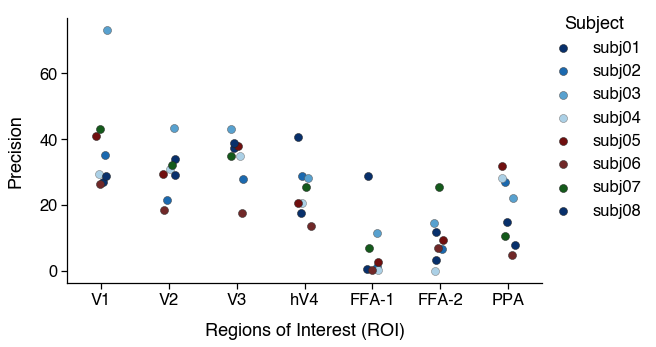

In [27]:
# Calculate median values for each subject and ROI
medians = all_df.groupby(['sub', 'ROI'])['value'].median().reset_index()
roi_list=['V1','V2','V3','hV4','FFA-1','FFA-2','PPA']
g= vis1D.plot_median_for_each_sub_and_roi(medians, 'ROI', 'value', x_order=roi_list,
                                           hue='sub',
                                           hue_order=sn_list,
                                           lgd_title='Subject',
                                           height=5,
                                           y_label=r"Precision",
                                           palette=retinotopy_colors(to_seaborn=True),
                                          save_path=None)

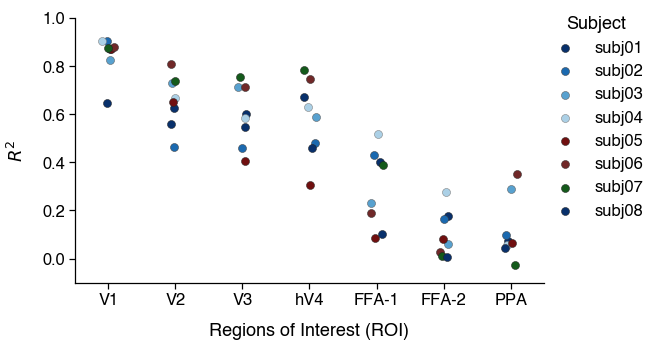

In [14]:
# Calculate median values for each subject and ROI
medians = all_df.groupby(['sub', 'ROI'])['value'].median().reset_index()
roi_list=['V1','V2','V3','hV4','FFA-1','FFA-2','PPA']
g= vis1D.plot_median_for_each_sub_and_roi(medians, 'ROI', 'value', x_order=roi_list,
                                           hue='sub',
                                           hue_order=sn_list,
                                           lgd_title='Subject',
                                           height=5,
                                           y_label=r"$R^2$",
                                           palette=retinotopy_colors(to_seaborn=True),
                                          save_path=None)

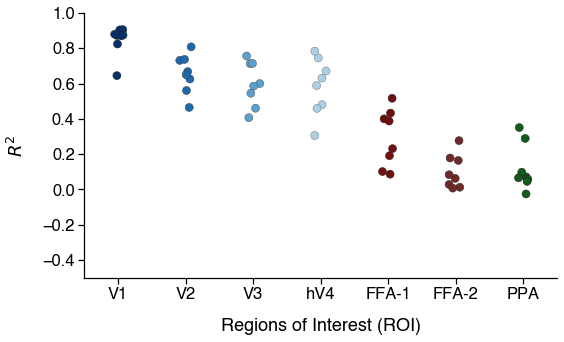

In [83]:
g.set(ylim=(-0.5, 1))

g.fig

In [13]:
ret_colors = sns.color_palette('Blues_r', as_cmap=True)
ret_colors = np.round(ret_colors(np.linspace(0, 1, 8)[::2])[:, 0:3] * 255).astype(int)
ret_colors = [np.asarray(ret_colors[k, :]) for k in range(3)] + [np.asarray(ret_colors[3, :])]
#
# Normalize RGB values to the 0-1 range
ret_colors = [(rgb / 255.0).tolist() for rgb in ret_colors]
# # Use the normalized_colors as a Seaborn palette
# ret_colors = sns.set_palette(sns.color_palette(ret_colors))

In [14]:
retinotopy_colors(to_seaborn=True)

TypeError: retinotopy_colors() missing 1 required positional argument: 'roi_list'

In [ ]:
# Set the size of the figure
sns.set_theme('notebook', font_scale=1.5)
save_path=os.path.join(fig_dir, 'boxplot_r2_all_rois_within_0-1.png')
plt.figure(figsize=(10, 6))  # Adjust the size as needed
ax = sns.boxplot(x='ROI', y='Goodness of fit (R2)', data=all_df, palette=palette, order=labels)
ax.set_ylabel('Goodness of fit (R2)')
ax.set_ylim(-0.2, 1.05)
ax.set_xlabel('ROIs')
plt.tight_layout()
utils.save_fig(save_path)

In [11]:
# Define a colormap from Matplotlib
cmap = plt.cm.get_cmap('Blues_r')

# Define the number of colors based on the number of ROIs
ret_colors = [cmap(i / 10) for i in range(10)]
colors = []
colors += [ret_colors[0], ret_colors[0], ret_colors[2], ret_colors[2], ret_colors[4], ret_colors[4], ret_colors[6]]
# Define a colormap from Matplotlib
colors += ['magenta', 'magenta']
colors += ['gray']
palette = dict(zip(labels, colors))

In [26]:
np.log10(all_df["Goodness of fit (R2)"].min())

/Users/jh7685/opt/miniconda3/envs/sfp/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


nan

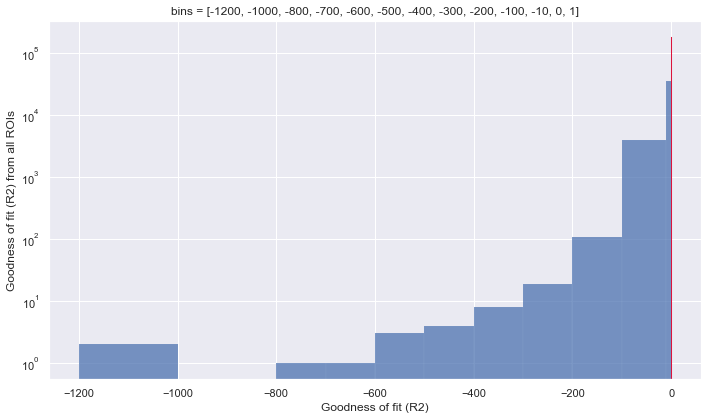

In [73]:
# Set the size of the figure
sns.set_theme()
save_path=os.path.join(fig_dir, 'histogram_r2_all_rois.png')
plt.figure(figsize=(10, 6))  # Adjust the size as needed
custom_palette = ['grey']*2 + ['red']*9
bin_edges = [-1200, -1000, -800, -700, -600, -500, -400, -300, -200, -100, -10, 0, 1]
ax = sns.histplot(x='Goodness of fit (R2)', data=all_df, bins=bin_edges, palette=custom_palette)
heights = [p.get_height() for p in ax.patches]
highest = sorted(heights)[-1]
for p in ax.patches:
    if  p.get_height() == highest:
        p.set_color('crimson')
ax.set_ylabel('Goodness of fit (R2) from all ROIs')
ax.set_yscale('log')
ax.set_title('bins = [-1200, -1000, -800, -700, -600, -500, -400, -300, -200, -100, -10, 0, 1]')
utils.save_fig(save_path)
plt.tight_layout()

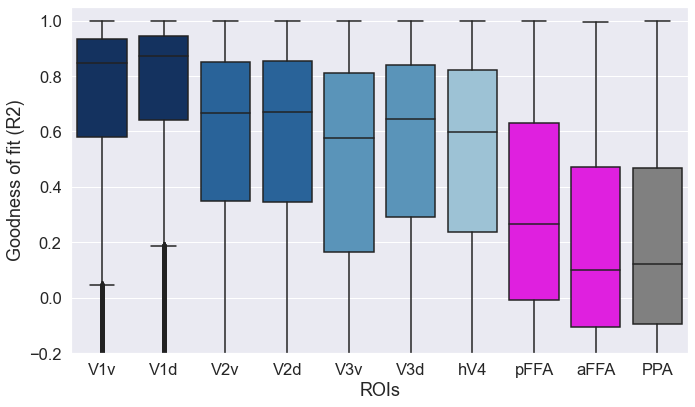

In [83]:
# Set the size of the figure
sns.set_theme('notebook', font_scale=1.5)
save_path=os.path.join(fig_dir, 'boxplot_r2_all_rois_within_0-1.png')
plt.figure(figsize=(10, 6))  # Adjust the size as needed
ax = sns.boxplot(x='ROI', y='Goodness of fit (R2)', data=all_df, palette=palette, order=labels)
ax.set_ylabel('Goodness of fit (R2)')
ax.set_ylim(-0.2, 1.05)
ax.set_xlabel('ROIs')
plt.tight_layout()
utils.save_fig(save_path)

# Tuning comparison

## Choose voxels based on what R2 value they have

In [151]:
# Define the bins
bins = [-2,0,0.3,0.4,0.9,1]

# Define the category labels
labels = ['-1 to 0', '0-0.3','0.3-0.4', '0.4-0.9', '<0.9']

# Applying the bins to the data
all_df['category'] = pd.cut(all_df['value'], bins=bins, labels=labels, right=False)

In [152]:
all_df

,value,voxel,ROI,hemi,sub,category
0,0.677695,813,V1,lh,subj01,0.4-0.9
1,0.944018,814,V1,lh,subj01,<0.9
2,0.842012,815,V1,lh,subj01,0.4-0.9
3,0.977396,816,V1,lh,subj01,<0.9
4,0.968446,817,V1,lh,subj01,<0.9
...,...,...,...,...,...,...
353,-0.733694,112652,A1,rh,subj08,-1 to 0
354,-0.694746,112653,A1,rh,subj08,-1 to 0
355,0.269222,112654,A1,rh,subj08,0-0.3
356,-0.248634,114179,A1,rh,subj08,-1 to 0


In [153]:
sampled_df = all_df.query('sub == "subj01" & hemi == "lh"')
sampled_df = sampled_df.groupby('category').apply(lambda x: x.sample(n=1, replace=False)).reset_index(drop=True)

In [154]:
voxel_list = sampled_df.sort_values('value').voxel.unique().tolist()

## Load in betas dataframe and merge it with the sampled df

In [155]:
subj='subj01'
hemi='lh'
betas = os.path.join(nsd_dir, 'nsddata_betas', 'ppdata', f'{subj}', 'nativesurface', 'nsdsyntheticbetas_fithrf_GLMdenoise_RR', f'{hemi}.betas_nsdsynthetic.hdf5')
design_mat=os.path.join(nsd_dir, 'nsddata', 'experiments', 'nsdsynthetic', 'nsdsynthetic_expdesign.mat')
task_keys=['fixation_task','memory_task']
stim_info=os.path.join(nsd_dir, 'nsdsyn_stim_description.csv')
task_average=True
eccentricity_path= os.path.join(nsd_dir, 'nsddata', 'freesurfer', f'{subj}', 'label',  f'{hemi}.prfeccentricity.mgz')

In [156]:
def load_in_sample_voxels(voxel_list, betas, design_mat, stim_info, task_keys, task_average, eccentricity_path, ref_frame):

    betas_df = sfm.get_whole_brain_betas(betas_path=betas, design_mat_path=design_mat,
                          stim_info_path=stim_info,
                          task_keys=task_keys, task_average=task_average, eccentricity_path=eccentricity_path,
                          x_axis='voxel', y_axis='stim_idx', long_format=True, reference_frame=ref_frame)
    betas_df = betas_df.query('voxel in @voxel_list')
    betas_df = betas_df.query('~names.str.contains("intermediate").values')
    betas_df = betas_df.groupby(['freq_lvl','voxel']).mean().reset_index()
    return betas_df


In [157]:
sampled_betas = load_in_sample_voxels(voxel_list, betas, design_mat, stim_info, task_keys, task_average, eccentricity_path, ref_frame)

In [158]:
sampled_p_opt = pd.read_hdf(os.path.join(output_dir, "sfp_maps", "voxel-tuning", "nsdsyn", f"hemi-{hemi}_sub-{subj}_frame-{ref_frame}.hdf"))
sampled_p_opt = sampled_p_opt.query('voxel in @voxel_list')

In [159]:
sampled_betas = sampled_betas.merge(sampled_df, on='voxel')

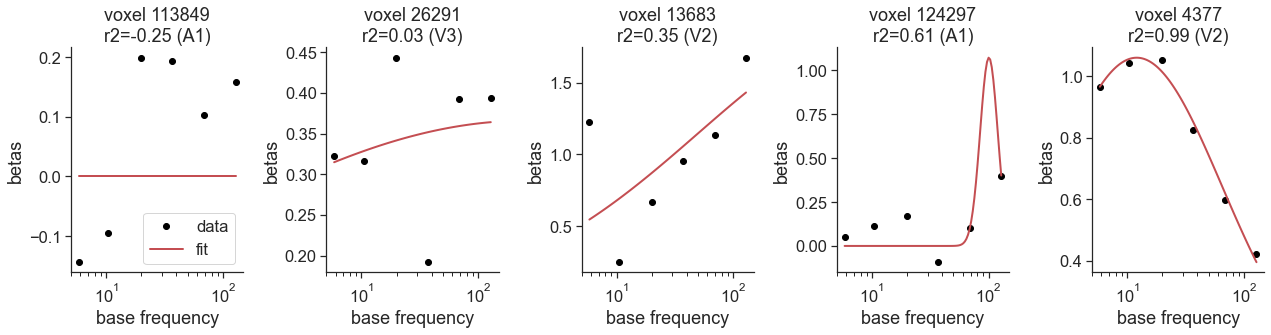

In [160]:
#fig, axes = plt.subplots(1,5, sharex=True, sharey=False, figsize=(11,17))

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.5)
fig, axes = plt.subplots(1,5, sharex=True, sharey=False, figsize=(18,5))

# Flatten the axes array for easy iteration
flat_axes = axes.flatten()
for i, v in enumerate(voxel_list):
    v_tmp = sampled_betas.query('voxel == @v')
    p_opt_tmp = sampled_p_opt.query('voxel == @v')
    r2_val = np.round(sampled_betas.query('voxel == @v')['value'].unique().item(), 2)
    roi = sampled_betas.query('voxel == @v')['ROI'].unique().item()
    tuning.plot_logGaussian_fit(v_tmp, 'local_sf', 'betas', p_opt_tmp, flat_axes[i], ax_title=f'voxel {v}\nr2={r2_val} ({roi})')
flat_axes[0].legend()
plt.savefig(os.path.join(fig_dir, 'subj01-lh-tuning-based-on-r2.png'), transparent=False)

In [163]:
a = [-0.1, -0.4, -0.6, -0.1]
np.sum((a - np.mean(a))**2)

0.17999999999999997

In [164]:
np.sum(a)

-1.2000000000000002